# 🚌 Customer Clustering for Long-Distance Bus Dispatch Automation

## Mục tiêu
Tự động hóa quy trình điều phối xe khách đường dài bằng cách phân cụm khách hàng dựa trên:
1. **Vị trí điểm đón** (pickup coordinates) - Khách có điểm đón gần nhau
2. **Thời gian khởi hành** (departure time) - Khách có thời gian khởi hành gần nhau

## Workflow
1. Phân tích và làm sạch dữ liệu (Data Cleaning)
2. Feature Engineering
3. Xây dựng mô hình Clustering (K-Means, DBSCAN)
4. Đánh giá và tối ưu hóa
5. Xuất kết quả để tích hợp vào ứng dụng

## 1. Import Libraries & Load Data

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Clustering libraries
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Geospatial calculations
from math import radians, sin, cos, sqrt, atan2

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [2]:
# Load mock data
DATA_PATH = '../data/mock_bookings_long_distance_1000.csv'
df = pd.read_csv(DATA_PATH)

print(f"📊 Dataset shape: {df.shape}")
print(f"📋 Columns: {df.columns.tolist()}")
df.head()

📊 Dataset shape: (1000, 14)
📋 Columns: ['client_id', 'created_at', 'departureDate', 'departureTime', 'destination', 'destination_coordinates_lat', 'destination_coordinates_lng', 'pickup', 'pickup_coordinates_lat', 'pickup_coordinates_lng', 'returnDate', 'state', 'timestamp', 'trip_id']


,client_id,created_at,departureDate,departureTime,destination,destination_coordinates_lat,destination_coordinates_lng,pickup,pickup_coordinates_lat,pickup_coordinates_lng,returnDate,state,timestamp,trip_id
0,jXNpXoiqNwMJ7aqzPGDqXGtEeoAw,2025-11-04T18:38:03.717831+07:00,04/11/2025,14:45,Van Don Ferry Terminal,20.653118,107.018416,Hanoi - My Dinh Bus Station,21.039535,106.036022,NaN,Completed,1762256283717,NaN
1,VH6pRA9NppXvWx9rHtXbsdqfpauG,2025-12-27T14:26:19.200261+07:00,27/12/2025,22:45,Hanoi - Long Bien Station,20.931912,105.791412,Cam Pha Bus Station,21.159575,107.474859,NaN,Completed,1766820379200,NaN
2,bHw9s6YHSHRdQsPTPfuAHCyjgYMb,2025-12-13T00:45:35.978092+07:00,13/12/2025,07:30,Hanoi - Luong Yen Station,21.227358,105.715977,Mong Cai Bus Station,21.062437,106.519003,NaN,Completed,1765561535978,NaN
3,ppG9UhBtbg3XWSk8WDdbQ3XGbhc1,2025-10-16T16:10:17.126534+07:00,16/10/2025,13:00,Ha Long - Tuan Chau Port,20.977060,106.493432,Hanoi - My Dinh Bus Station,20.904230,105.679686,NaN,Completed,1760605817126,NaN
4,fyfwdwDN9U7JNaWwncvaCMdumReX,2025-10-11T10:22:54.072155+07:00,11/10/2025,17:45,Hanoi - Long Bien Station,20.704991,105.599908,Cam Pha Bus Station,20.918885,106.570949,NaN,Completed,1760152974072,NaN


## 2. Data Exploration & Analysis

In [3]:
# Basic info about the dataset
print("=" * 50)
print("📊 DATASET INFO")
print("=" * 50)
print(f"\nTotal records: {len(df)}")
print(f"Unique clients: {df['client_id'].nunique()}")
print(f"\n📍 Pickup locations:")
print(df['pickup'].value_counts())
print(f"\n🎯 Destination locations:")
print(df['destination'].value_counts())

📊 DATASET INFO

Total records: 1000
Unique clients: 199

📍 Pickup locations:
pickup
Ha Long - Tuan Chau Port       100
Hanoi - Gia Lam Station         91
Mong Cai Bus Station            90
Van Don Ferry Terminal          90
Ha Long - Bai Chay Station      88
Hanoi - Giap Bat Station        87
Uong Bi Bus Station             87
Hanoi - Long Bien Station       83
Cam Pha Bus Station             74
Hanoi - Luong Yen Station       73
Hanoi - My Dinh Bus Station     69
Hanoi - Yen Nghia Station       68
Name: count, dtype: int64

🎯 Destination locations:
destination
Hanoi - Gia Lam Station        100
Hanoi - Yen Nghia Station       99
Hanoi - Long Bien Station       98
Hanoi - My Dinh Bus Station     91
Mong Cai Bus Station            90
Uong Bi Bus Station             85
Van Don Ferry Terminal          79
Hanoi - Luong Yen Station       79
Ha Long - Tuan Chau Port        79
Ha Long - Bai Chay Station      75
Cam Pha Bus Station             63
Hanoi - Giap Bat Station        62
Name: count,

In [4]:
# Data types and missing values
print("\n📋 DATA TYPES")
print(df.dtypes)
print("\n❓ MISSING VALUES")
print(df.isnull().sum())
print("\n📈 STATISTICAL SUMMARY")
df.describe()


📋 DATA TYPES
client_id                       object
created_at                      object
departureDate                   object
departureTime                   object
destination                     object
destination_coordinates_lat    float64
destination_coordinates_lng    float64
pickup                          object
pickup_coordinates_lat         float64
pickup_coordinates_lng         float64
returnDate                     float64
state                           object
timestamp                        int64
trip_id                        float64
dtype: object

❓ MISSING VALUES
client_id                         0
created_at                        0
departureDate                     0
departureTime                     0
destination                       0
destination_coordinates_lat       0
destination_coordinates_lng       0
pickup                            0
pickup_coordinates_lat            0
pickup_coordinates_lng            0
returnDate                     1000
state       

,destination_coordinates_lat,destination_coordinates_lng,pickup_coordinates_lat,pickup_coordinates_lng,returnDate,timestamp,trip_id
count,1000.000000,1000.000000,1000.000000,1000.000000,0.0,1.000000e+03,0.0
mean,20.946111,106.341875,20.945441,106.404245,NaN,1.763834e+12,NaN
std,0.181425,0.629160,0.175171,0.625761,NaN,2.284276e+09,NaN
min,20.600652,105.500208,20.602732,105.500165,NaN,1.759851e+12,NaN
25%,20.793285,105.765669,20.806522,105.806503,NaN,1.761940e+12,NaN
50%,20.945035,106.064442,20.945715,106.469394,NaN,1.763823e+12,NaN
75%,21.099023,106.904381,21.089633,106.964465,NaN,1.765802e+12,NaN
max,21.299971,107.498684,21.296355,107.498431,NaN,1.767614e+12,NaN


In [ ]:
# Analyze departure time distribution
print("\n⏰ DEPARTURE TIME DISTRIBUTION")
print(df['departureTime'].value_counts().head(20))

## 3. Data Cleaning

In [5]:
def clean_data(df):
    """
    Clean and preprocess the booking data
    """
    df_clean = df.copy()
    
    # 1. Check for missing coordinates
    print("🔍 Checking for missing coordinates...")
    missing_pickup = df_clean[['pickup_coordinates_lat', 'pickup_coordinates_lng']].isnull().any(axis=1).sum()
    missing_dest = df_clean[['destination_coordinates_lat', 'destination_coordinates_lng']].isnull().any(axis=1).sum()
    print(f"   Missing pickup coordinates: {missing_pickup}")
    print(f"   Missing destination coordinates: {missing_dest}")
    
    # 2. Remove rows with missing coordinates
    df_clean = df_clean.dropna(subset=['pickup_coordinates_lat', 'pickup_coordinates_lng'])
    
    # 3. Convert departure date to datetime
    print("\n📅 Converting date formats...")
    df_clean['departure_datetime'] = pd.to_datetime(
        df_clean['departureDate'] + ' ' + df_clean['departureTime'],
        format='%d/%m/%Y %H:%M'
    )
    
    # 4. Extract time features
    df_clean['departure_hour'] = df_clean['departure_datetime'].dt.hour
    df_clean['departure_minute'] = df_clean['departure_datetime'].dt.minute
    df_clean['departure_day'] = df_clean['departure_datetime'].dt.day
    df_clean['departure_month'] = df_clean['departure_datetime'].dt.month
    df_clean['departure_dayofweek'] = df_clean['departure_datetime'].dt.dayofweek
    
    # 5. Convert time to minutes since midnight for easier comparison
    df_clean['departure_time_minutes'] = df_clean['departure_hour'] * 60 + df_clean['departure_minute']
    
    # 6. Validate coordinates are within expected ranges
    print("\n🗺️ Validating coordinates...")
    # Hanoi: 20.70-21.30 lat, 105.50-106.10 lng
    # Quang Ninh: 20.60-21.20 lat, 106.40-107.50 lng
    lat_range = (20.5, 21.5)
    lng_range = (105.4, 107.6)
    
    valid_coords = (
        (df_clean['pickup_coordinates_lat'] >= lat_range[0]) & 
        (df_clean['pickup_coordinates_lat'] <= lat_range[1]) &
        (df_clean['pickup_coordinates_lng'] >= lng_range[0]) & 
        (df_clean['pickup_coordinates_lng'] <= lng_range[1])
    )
    
    invalid_count = (~valid_coords).sum()
    print(f"   Invalid coordinates found: {invalid_count}")
    
    # 7. Identify direction (Hanoi -> Quang Ninh or vice versa)
    df_clean['direction'] = df_clean['pickup'].apply(
        lambda x: 'Hanoi_to_QuangNinh' if 'Hanoi' in x else 'QuangNinh_to_Hanoi'
    )
    
    print(f"\n✅ Cleaning complete! Remaining records: {len(df_clean)}")
    return df_clean

# Apply cleaning
df_clean = clean_data(df)

🔍 Checking for missing coordinates...
   Missing pickup coordinates: 0
   Missing destination coordinates: 0

📅 Converting date formats...

🗺️ Validating coordinates...
   Invalid coordinates found: 0

✅ Cleaning complete! Remaining records: 1000


In [6]:
# View cleaned data
print("📊 Cleaned data sample:")
df_clean[['client_id', 'pickup', 'destination', 'departureDate', 'departureTime', 
          'pickup_coordinates_lat', 'pickup_coordinates_lng', 'departure_time_minutes', 'direction']].head(10)

📊 Cleaned data sample:


,client_id,pickup,destination,departureDate,departureTime,pickup_coordinates_lat,pickup_coordinates_lng,departure_time_minutes,direction
0,jXNpXoiqNwMJ7aqzPGDqXGtEeoAw,Hanoi - My Dinh Bus Station,Van Don Ferry Terminal,04/11/2025,14:45,21.039535,106.036022,885,Hanoi_to_QuangNinh
1,VH6pRA9NppXvWx9rHtXbsdqfpauG,Cam Pha Bus Station,Hanoi - Long Bien Station,27/12/2025,22:45,21.159575,107.474859,1365,QuangNinh_to_Hanoi
2,bHw9s6YHSHRdQsPTPfuAHCyjgYMb,Mong Cai Bus Station,Hanoi - Luong Yen Station,13/12/2025,07:30,21.062437,106.519003,450,QuangNinh_to_Hanoi
3,ppG9UhBtbg3XWSk8WDdbQ3XGbhc1,Hanoi - My Dinh Bus Station,Ha Long - Tuan Chau Port,16/10/2025,13:00,20.904230,105.679686,780,Hanoi_to_QuangNinh
4,fyfwdwDN9U7JNaWwncvaCMdumReX,Cam Pha Bus Station,Hanoi - Long Bien Station,11/10/2025,17:45,20.918885,106.570949,1065,QuangNinh_to_Hanoi
5,VXySnu4Jmtyr2897SvWJJLsXBrSQ,Hanoi - My Dinh Bus Station,Van Don Ferry Terminal,03/01/2026,21:45,20.773014,105.688985,1305,Hanoi_to_QuangNinh
6,Ky86bwZ1Qm4TX6NZYfrfm2g81uoV,Uong Bi Bus Station,Hanoi - Giap Bat Station,26/11/2025,17:30,21.051040,106.455187,1050,QuangNinh_to_Hanoi
7,TyfTGXUhgtNPrNfUztzQdtau3NA3,Uong Bi Bus Station,Hanoi - Long Bien Station,01/01/2026,12:00,20.963712,107.042620,720,QuangNinh_to_Hanoi
8,MQx0QVqcf4fCT5x73UvFrCT470fX,Uong Bi Bus Station,Hanoi - Long Bien Station,01/12/2025,21:45,20.655262,106.423693,1305,QuangNinh_to_Hanoi
9,EUZqzUcC38ndZ4rkUXyz9CBfrTwj,Van Don Ferry Terminal,Hanoi - Yen Nghia Station,23/11/2025,10:15,20.834541,107.020613,615,QuangNinh_to_Hanoi


## 4. Data Visualization

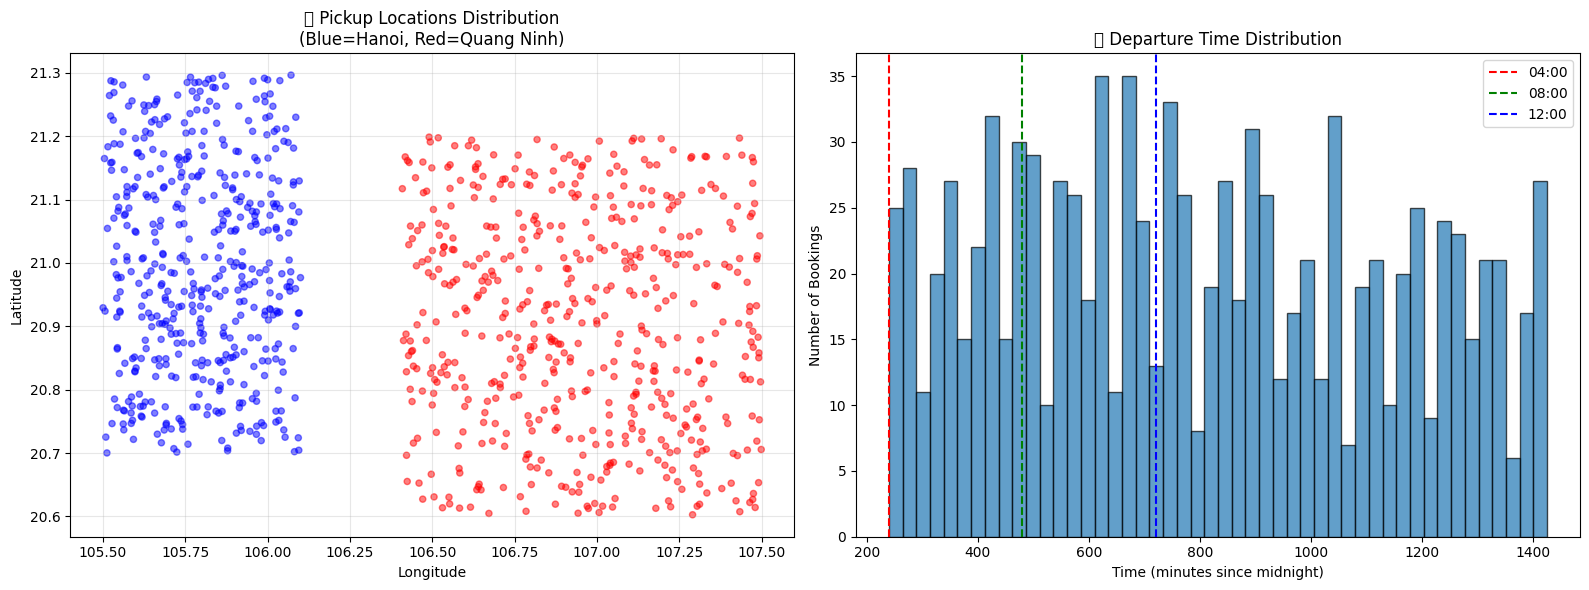

✅ Visualization saved to ../data/pickup_distribution.png


In [7]:
# Visualize pickup locations on a scatter plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: All pickup locations
colors = ['blue' if 'Hanoi' in p else 'red' for p in df_clean['pickup']]
axes[0].scatter(df_clean['pickup_coordinates_lng'], df_clean['pickup_coordinates_lat'], 
                c=colors, alpha=0.5, s=20)
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title('📍 Pickup Locations Distribution\n(Blue=Hanoi, Red=Quang Ninh)')
axes[0].grid(True, alpha=0.3)

# Plot 2: Departure time distribution
axes[1].hist(df_clean['departure_time_minutes'], bins=48, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Time (minutes since midnight)')
axes[1].set_ylabel('Number of Bookings')
axes[1].set_title('⏰ Departure Time Distribution')
axes[1].axvline(x=240, color='r', linestyle='--', label='04:00')
axes[1].axvline(x=480, color='g', linestyle='--', label='08:00')
axes[1].axvline(x=720, color='b', linestyle='--', label='12:00')
axes[1].legend()

plt.tight_layout()
plt.savefig('../data/pickup_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Visualization saved to ../data/pickup_distribution.png")

In [ ]:
# Departure time by day of week
fig, ax = plt.subplots(figsize=(12, 5))

day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_clean['day_name'] = df_clean['departure_dayofweek'].apply(lambda x: day_names[x])

day_counts = df_clean['day_name'].value_counts().reindex(day_names)
ax.bar(day_names, day_counts, color='steelblue', edgecolor='black')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Number of Bookings')
ax.set_title('📅 Bookings by Day of Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5. Feature Engineering for Clustering

In [8]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance (km) between two points on earth
    """
    R = 6371  # Earth's radius in kilometers
    
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    
    return R * c

def prepare_clustering_features(df, date_filter=None, direction_filter=None):
    """
    Prepare features for clustering:
    - Pickup coordinates (lat, lng)
    - Departure time (minutes since midnight)
    - Optional: filter by date and direction
    """
    df_filtered = df.copy()
    
    # Filter by date if specified
    if date_filter:
        df_filtered = df_filtered[df_filtered['departureDate'] == date_filter]
    
    # Filter by direction if specified
    if direction_filter:
        df_filtered = df_filtered[df_filtered['direction'] == direction_filter]
    
    if len(df_filtered) == 0:
        print("⚠️ No data after filtering!")
        return None, None
    
    # Features for clustering
    features = df_filtered[[
        'pickup_coordinates_lat',
        'pickup_coordinates_lng',
        'departure_time_minutes'
    ]].copy()
    
    print(f"📊 Prepared {len(features)} samples for clustering")
    return df_filtered, features

# Test the function
df_sample, features_sample = prepare_clustering_features(
    df_clean, 
    direction_filter='Hanoi_to_QuangNinh'
)
print(f"\n📍 Features shape: {features_sample.shape}")
features_sample.head()

📊 Prepared 471 samples for clustering

📍 Features shape: (471, 3)


,pickup_coordinates_lat,pickup_coordinates_lng,departure_time_minutes
0,21.039535,106.036022,885
3,20.904230,105.679686,780
5,20.773014,105.688985,1305
12,20.864032,105.994486,660
13,20.945864,105.800441,585


In [9]:
def scale_features(features, coord_weight=1.0, time_weight=0.5):
    """
    Scale features with custom weights:
    - coord_weight: weight for geographic coordinates
    - time_weight: weight for time feature
    
    The weights control the relative importance of location vs time in clustering.
    Higher coord_weight = clusters prioritize geographic proximity
    Higher time_weight = clusters prioritize similar departure times
    """
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Apply weights
    features_scaled[:, 0] *= coord_weight  # lat
    features_scaled[:, 1] *= coord_weight  # lng
    features_scaled[:, 2] *= time_weight   # time
    
    return features_scaled, scaler

# Test scaling
features_scaled, scaler = scale_features(features_sample)
print(f"✅ Scaled features shape: {features_scaled.shape}")
print(f"   Mean: {features_scaled.mean(axis=0)}")
print(f"   Std: {features_scaled.std(axis=0)}")

✅ Scaled features shape: (471, 3)
   Mean: [-1.12389456e-15  5.94758967e-15 -2.73430724e-17]
   Std: [1.  1.  0.5]


## 6. K-Means Clustering

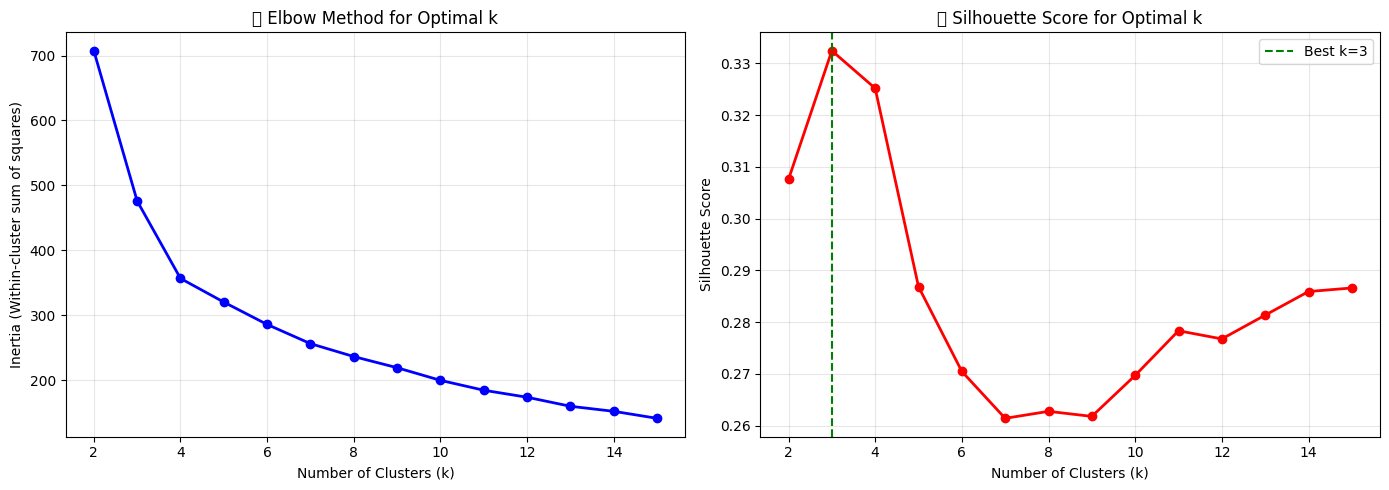


✅ Best k by Silhouette Score: 3
   Silhouette Score: 0.3324


In [10]:
def find_optimal_k(features_scaled, k_range=(2, 15)):
    """
    Find optimal number of clusters using Elbow method and Silhouette score
    """
    inertias = []
    silhouette_scores = []
    k_values = range(k_range[0], k_range[1] + 1)
    
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(features_scaled)
        inertias.append(kmeans.inertia_)
        
        if k > 1:
            score = silhouette_score(features_scaled, kmeans.labels_)
            silhouette_scores.append(score)
        else:
            silhouette_scores.append(0)
    
    # Plot results
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Elbow plot
    axes[0].plot(k_values, inertias, 'bo-', linewidth=2)
    axes[0].set_xlabel('Number of Clusters (k)')
    axes[0].set_ylabel('Inertia (Within-cluster sum of squares)')
    axes[0].set_title('📈 Elbow Method for Optimal k')
    axes[0].grid(True, alpha=0.3)
    
    # Silhouette plot
    axes[1].plot(k_values, silhouette_scores, 'ro-', linewidth=2)
    axes[1].set_xlabel('Number of Clusters (k)')
    axes[1].set_ylabel('Silhouette Score')
    axes[1].set_title('📊 Silhouette Score for Optimal k')
    axes[1].grid(True, alpha=0.3)
    
    # Find best k by silhouette score
    best_k = k_values[np.argmax(silhouette_scores)]
    axes[1].axvline(x=best_k, color='g', linestyle='--', label=f'Best k={best_k}')
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig('../data/optimal_k_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✅ Best k by Silhouette Score: {best_k}")
    print(f"   Silhouette Score: {max(silhouette_scores):.4f}")
    
    return best_k, silhouette_scores

# Find optimal k
best_k, scores = find_optimal_k(features_scaled)

In [11]:
def perform_kmeans_clustering(df, features_scaled, n_clusters, coord_weight=1.0, time_weight=0.5):
    """
    Perform K-Means clustering and return results
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(features_scaled)
    
    # Add cluster labels to dataframe
    df_result = df.copy()
    df_result['cluster'] = clusters
    
    # Calculate metrics
    silhouette = silhouette_score(features_scaled, clusters)
    calinski = calinski_harabasz_score(features_scaled, clusters)
    
    print(f"\n🎯 K-MEANS CLUSTERING RESULTS (k={n_clusters})")
    print("=" * 50)
    print(f"   Silhouette Score: {silhouette:.4f}")
    print(f"   Calinski-Harabasz Score: {calinski:.4f}")
    print(f"   Feature weights: coord={coord_weight}, time={time_weight}")
    print("\n📊 Cluster Distribution:")
    print(df_result['cluster'].value_counts().sort_index())
    
    return df_result, kmeans, silhouette

# Perform clustering with best k
df_clustered, kmeans_model, sil_score = perform_kmeans_clustering(
    df_sample, features_scaled, n_clusters=best_k
)


🎯 K-MEANS CLUSTERING RESULTS (k=3)
   Silhouette Score: 0.3324
   Calinski-Harabasz Score: 287.0850
   Feature weights: coord=1.0, time=0.5

📊 Cluster Distribution:
cluster
0    126
1    181
2    164
Name: count, dtype: int64


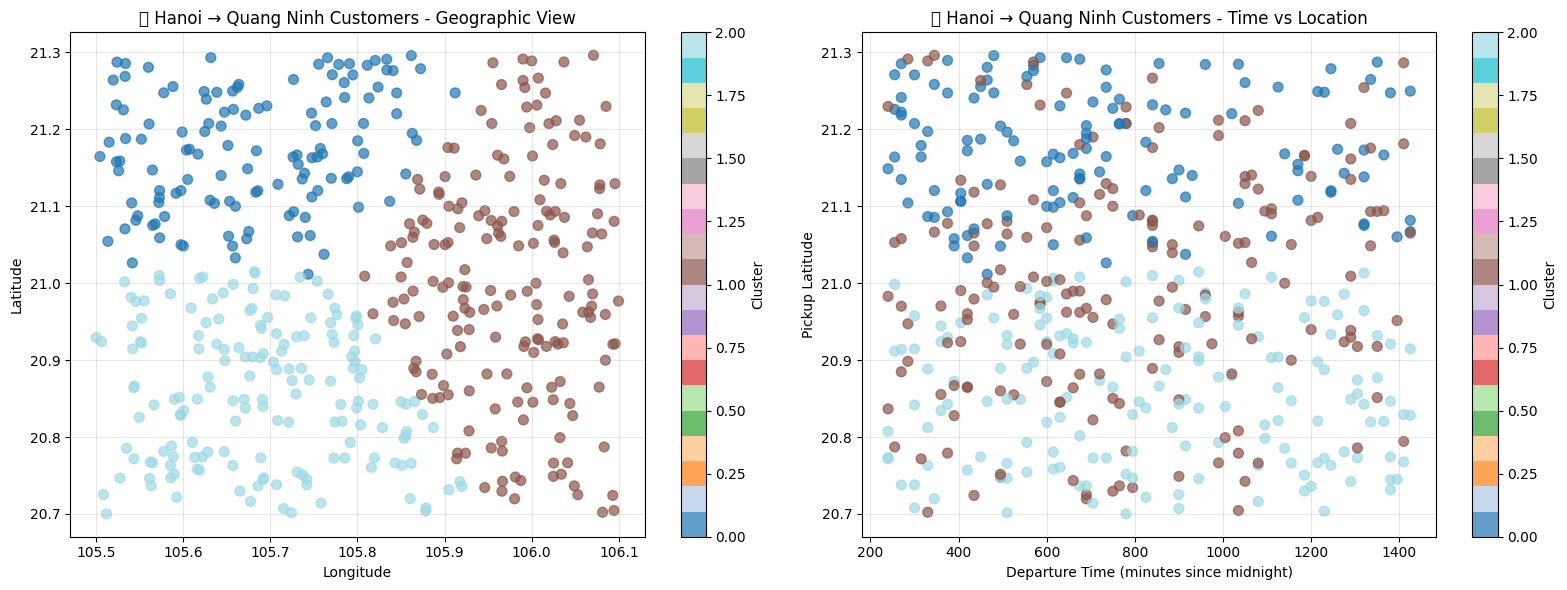

In [12]:
def visualize_clusters(df_clustered, title="Customer Clusters"):
    """
    Visualize clustering results
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Geographic clusters
    scatter = axes[0].scatter(
        df_clustered['pickup_coordinates_lng'],
        df_clustered['pickup_coordinates_lat'],
        c=df_clustered['cluster'],
        cmap='tab20',
        alpha=0.7,
        s=50
    )
    axes[0].set_xlabel('Longitude')
    axes[0].set_ylabel('Latitude')
    axes[0].set_title(f'📍 {title} - Geographic View')
    plt.colorbar(scatter, ax=axes[0], label='Cluster')
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Time vs Location
    scatter2 = axes[1].scatter(
        df_clustered['departure_time_minutes'],
        df_clustered['pickup_coordinates_lat'],
        c=df_clustered['cluster'],
        cmap='tab20',
        alpha=0.7,
        s=50
    )
    axes[1].set_xlabel('Departure Time (minutes since midnight)')
    axes[1].set_ylabel('Pickup Latitude')
    axes[1].set_title(f'⏰ {title} - Time vs Location')
    plt.colorbar(scatter2, ax=axes[1], label='Cluster')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../data/cluster_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()

visualize_clusters(df_clustered, "Hanoi → Quang Ninh Customers")

## 7. DBSCAN Clustering (Alternative)

In [ ]:
def perform_dbscan_clustering(df, features_scaled, eps=0.5, min_samples=3):
    """
    Perform DBSCAN clustering - useful for finding natural clusters
    without specifying the number of clusters
    """
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(features_scaled)
    
    df_result = df.copy()
    df_result['cluster_dbscan'] = clusters
    
    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    n_noise = list(clusters).count(-1)
    
    print(f"\n🎯 DBSCAN CLUSTERING RESULTS")
    print("=" * 50)
    print(f"   Parameters: eps={eps}, min_samples={min_samples}")
    print(f"   Number of clusters: {n_clusters}")
    print(f"   Noise points: {n_noise} ({n_noise/len(df)*100:.1f}%)")
    
    if n_clusters > 1:
        # Calculate silhouette only for non-noise points
        mask = clusters != -1
        if mask.sum() > 1:
            silhouette = silhouette_score(features_scaled[mask], clusters[mask])
            print(f"   Silhouette Score (excl. noise): {silhouette:.4f}")
    
    print("\n📊 Cluster Distribution:")
    print(df_result['cluster_dbscan'].value_counts().sort_index())
    
    return df_result, dbscan

# Test different DBSCAN parameters
df_dbscan, dbscan_model = perform_dbscan_clustering(
    df_sample, features_scaled, eps=0.8, min_samples=5
)

## 8. Dispatch Optimization - Grouping Customers

In [13]:
def analyze_clusters_for_dispatch(df_clustered, max_passengers_per_trip=20):
    """
    Analyze clusters for dispatch optimization
    - Show cluster statistics
    - Suggest trip groupings
    """
    print("\n🚌 DISPATCH ANALYSIS")
    print("=" * 60)
    
    cluster_stats = []
    
    for cluster_id in sorted(df_clustered['cluster'].unique()):
        cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]
        
        stats = {
            'cluster_id': cluster_id,
            'num_customers': len(cluster_data),
            'avg_lat': cluster_data['pickup_coordinates_lat'].mean(),
            'avg_lng': cluster_data['pickup_coordinates_lng'].mean(),
            'avg_time': cluster_data['departure_time_minutes'].mean(),
            'min_time': cluster_data['departure_time_minutes'].min(),
            'max_time': cluster_data['departure_time_minutes'].max(),
            'time_range': cluster_data['departure_time_minutes'].max() - cluster_data['departure_time_minutes'].min(),
            'pickup_stations': cluster_data['pickup'].unique().tolist()
        }
        
        # Convert avg time to HH:MM format
        hours = int(stats['avg_time'] // 60)
        minutes = int(stats['avg_time'] % 60)
        stats['avg_time_str'] = f"{hours:02d}:{minutes:02d}"
        
        cluster_stats.append(stats)
        
        # Calculate number of trips needed
        trips_needed = max(1, (len(cluster_data) + max_passengers_per_trip - 1) // max_passengers_per_trip)
        
        print(f"\n📍 Cluster {cluster_id}:")
        print(f"   Customers: {stats['num_customers']}")
        print(f"   Trips needed: {trips_needed} (max {max_passengers_per_trip} passengers/trip)")
        print(f"   Average departure: {stats['avg_time_str']}")
        print(f"   Time range: {stats['time_range']} minutes")
        print(f"   Pickup stations: {', '.join(stats['pickup_stations'])}")
        print(f"   Centroid: ({stats['avg_lat']:.4f}, {stats['avg_lng']:.4f})")
    
    return pd.DataFrame(cluster_stats)

# Analyze clusters
cluster_stats_df = analyze_clusters_for_dispatch(df_clustered, max_passengers_per_trip=15)


🚌 DISPATCH ANALYSIS

📍 Cluster 0:
   Customers: 126
   Trips needed: 9 (max 15 passengers/trip)
   Average departure: 11:58
   Time range: 1185 minutes
   Pickup stations: Hanoi - Giap Bat Station, Hanoi - Luong Yen Station, Hanoi - Gia Lam Station, Hanoi - Long Bien Station, Hanoi - Yen Nghia Station, Hanoi - My Dinh Bus Station
   Centroid: (21.1732, 105.6823)

📍 Cluster 1:
   Customers: 181
   Trips needed: 13 (max 15 passengers/trip)
   Average departure: 13:03
   Time range: 1185 minutes
   Pickup stations: Hanoi - My Dinh Bus Station, Hanoi - Yen Nghia Station, Hanoi - Gia Lam Station, Hanoi - Long Bien Station, Hanoi - Luong Yen Station, Hanoi - Giap Bat Station
   Centroid: (20.9970, 105.9744)

📍 Cluster 2:
   Customers: 164
   Trips needed: 11 (max 15 passengers/trip)
   Average departure: 13:57
   Time range: 1185 minutes
   Pickup stations: Hanoi - My Dinh Bus Station, Hanoi - Giap Bat Station, Hanoi - Gia Lam Station, Hanoi - Luong Yen Station, Hanoi - Long Bien Station, H

In [ ]:
# Display cluster summary table
print("\n📊 CLUSTER SUMMARY TABLE")
display_cols = ['cluster_id', 'num_customers', 'avg_time_str', 'time_range', 'avg_lat', 'avg_lng']
cluster_stats_df[display_cols]

## 9. Full Pipeline - Automated Dispatch

In [14]:
class CustomerDispatcher:
    """
    Automated customer dispatch system using clustering
    """
    
    def __init__(self, coord_weight=1.0, time_weight=0.5, max_passengers=20):
        self.coord_weight = coord_weight
        self.time_weight = time_weight
        self.max_passengers = max_passengers
        self.scaler = StandardScaler()
        self.model = None
        
    def preprocess(self, df):
        """
        Preprocess data for clustering
        """
        df_processed = df.copy()
        
        # Parse datetime
        df_processed['departure_datetime'] = pd.to_datetime(
            df_processed['departureDate'] + ' ' + df_processed['departureTime'],
            format='%d/%m/%Y %H:%M'
        )
        df_processed['departure_time_minutes'] = (
            df_processed['departure_datetime'].dt.hour * 60 + 
            df_processed['departure_datetime'].dt.minute
        )
        
        # Identify direction
        df_processed['direction'] = df_processed['pickup'].apply(
            lambda x: 'Hanoi_to_QuangNinh' if 'Hanoi' in x else 'QuangNinh_to_Hanoi'
        )
        
        return df_processed
    
    def extract_features(self, df):
        """
        Extract and scale features
        """
        features = df[[
            'pickup_coordinates_lat',
            'pickup_coordinates_lng',
            'departure_time_minutes'
        ]].values
        
        features_scaled = self.scaler.fit_transform(features)
        
        # Apply weights
        features_scaled[:, 0] *= self.coord_weight
        features_scaled[:, 1] *= self.coord_weight
        features_scaled[:, 2] *= self.time_weight
        
        return features_scaled
    
    def find_optimal_clusters(self, features_scaled, min_k=2, max_k=15):
        """
        Find optimal number of clusters using silhouette score
        """
        best_k = min_k
        best_score = -1
        
        for k in range(min_k, min(max_k + 1, len(features_scaled))):
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(features_scaled)
            score = silhouette_score(features_scaled, labels)
            
            if score > best_score:
                best_score = score
                best_k = k
        
        return best_k
    
    def cluster_customers(self, df, date_filter=None, direction_filter=None, n_clusters=None):
        """
        Main clustering method
        """
        # Preprocess
        df_processed = self.preprocess(df)
        
        # Filter data
        if date_filter:
            df_processed = df_processed[df_processed['departureDate'] == date_filter]
        if direction_filter:
            df_processed = df_processed[df_processed['direction'] == direction_filter]
        
        if len(df_processed) < 2:
            print("⚠️ Not enough data points for clustering")
            return df_processed, None
        
        # Extract features
        features_scaled = self.extract_features(df_processed)
        
        # Find optimal clusters if not specified
        if n_clusters is None:
            n_clusters = self.find_optimal_clusters(features_scaled)
        
        # Perform clustering
        self.model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        df_processed['cluster'] = self.model.fit_predict(features_scaled)
        
        return df_processed, self.model
    
    def generate_trips(self, df_clustered):
        """
        Generate trip assignments from clusters
        """
        trips = []
        trip_id = 1
        
        for cluster_id in sorted(df_clustered['cluster'].unique()):
            cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]
            
            # Split into multiple trips if exceeds max passengers
            for i in range(0, len(cluster_data), self.max_passengers):
                trip_customers = cluster_data.iloc[i:i + self.max_passengers]
                
                # Calculate trip time (average of customer times)
                avg_time = trip_customers['departure_time_minutes'].mean()
                hours = int(avg_time // 60)
                minutes = int(avg_time % 60)
                
                trip = {
                    'trip_id': f"TRIP_{trip_id:03d}",
                    'cluster_id': cluster_id,
                    'num_passengers': len(trip_customers),
                    'suggested_departure_time': f"{hours:02d}:{minutes:02d}",
                    'pickup_lat_center': trip_customers['pickup_coordinates_lat'].mean(),
                    'pickup_lng_center': trip_customers['pickup_coordinates_lng'].mean(),
                    'customer_ids': trip_customers['client_id'].tolist(),
                    'departure_date': trip_customers['departureDate'].iloc[0]
                }
                trips.append(trip)
                trip_id += 1
        
        return pd.DataFrame(trips)

# Test the dispatcher
print("🚌 Testing CustomerDispatcher...")
dispatcher = CustomerDispatcher(coord_weight=1.0, time_weight=0.5, max_passengers=15)

# Cluster all Hanoi to Quang Ninh customers
df_clustered_auto, model = dispatcher.cluster_customers(
    df, 
    direction_filter='Hanoi_to_QuangNinh'
)

print(f"\n✅ Clustered {len(df_clustered_auto)} customers into {df_clustered_auto['cluster'].nunique()} groups")

🚌 Testing CustomerDispatcher...

✅ Clustered 471 customers into 3 groups


In [15]:
# Generate trip assignments
trips_df = dispatcher.generate_trips(df_clustered_auto)

print("\n🚌 GENERATED TRIPS")
print("=" * 60)
trips_df[['trip_id', 'num_passengers', 'suggested_departure_time', 'departure_date', 'pickup_lat_center', 'pickup_lng_center']]


🚌 GENERATED TRIPS


,trip_id,num_passengers,suggested_departure_time,departure_date,pickup_lat_center,pickup_lng_center
0,TRIP_001,15,13:33,30/12/2025,21.174190,105.668377
1,TRIP_002,15,10:15,07/12/2025,21.171201,105.714036
2,TRIP_003,15,13:17,13/12/2025,21.163988,105.706878
3,TRIP_004,15,13:38,11/10/2025,21.151338,105.674423
4,TRIP_005,15,11:43,26/11/2025,21.186099,105.694857
5,TRIP_006,15,10:06,31/12/2025,21.190577,105.667952
6,TRIP_007,15,13:03,14/11/2025,21.172591,105.655289
7,TRIP_008,15,10:33,23/12/2025,21.178229,105.663325
8,TRIP_009,6,11:12,02/11/2025,21.167710,105.715243
9,TRIP_010,15,12:41,04/11/2025,21.020879,105.989024


In [16]:
# Export results
def export_results(df_clustered, trips_df, output_dir='../data'):
    """
    Export clustering results to CSV files
    """
    # Export clustered customers
    customer_output = df_clustered[[
        'client_id', 'pickup', 'destination', 'departureDate', 'departureTime',
        'pickup_coordinates_lat', 'pickup_coordinates_lng', 'cluster'
    ]]
    customer_output.to_csv(f'{output_dir}/clustered_customers.csv', index=False)
    
    # Export trips
    trips_df.to_csv(f'{output_dir}/generated_trips.csv', index=False)
    
    print(f"✅ Exported results to:")
    print(f"   - {output_dir}/clustered_customers.csv")
    print(f"   - {output_dir}/generated_trips.csv")

export_results(df_clustered_auto, trips_df)

✅ Exported results to:
   - ../data/clustered_customers.csv
   - ../data/generated_trips.csv


## 10. Parameter Tuning & Experiments

In [ ]:
def experiment_weights(df, coord_weights=[0.5, 1.0, 1.5, 2.0], time_weights=[0.3, 0.5, 1.0, 1.5]):
    """
    Experiment with different weight combinations
    """
    results = []
    
    for cw in coord_weights:
        for tw in time_weights:
            dispatcher = CustomerDispatcher(coord_weight=cw, time_weight=tw)
            df_result, model = dispatcher.cluster_customers(df, direction_filter='Hanoi_to_QuangNinh')
            
            if model is not None:
                features_scaled = dispatcher.extract_features(df_result)
                silhouette = silhouette_score(features_scaled, df_result['cluster'])
                n_clusters = df_result['cluster'].nunique()
                
                results.append({
                    'coord_weight': cw,
                    'time_weight': tw,
                    'n_clusters': n_clusters,
                    'silhouette_score': silhouette
                })
    
    return pd.DataFrame(results)

# Run experiments
print("🔬 Running weight experiments...")
experiment_results = experiment_weights(df)
experiment_results.sort_values('silhouette_score', ascending=False).head(10)

In [ ]:
# Visualize experiment results
pivot_table = experiment_results.pivot_table(
    values='silhouette_score', 
    index='coord_weight', 
    columns='time_weight'
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='YlOrRd')
plt.title('🔬 Silhouette Score by Weight Combinations')
plt.xlabel('Time Weight')
plt.ylabel('Coordinate Weight')
plt.tight_layout()
plt.savefig('../data/weight_experiment_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## 11. Save Model for Production

In [17]:
import pickle
import json

def save_model(dispatcher, model, scaler, output_dir='../data'):
    """
    Save trained model and configuration for production use
    """
    # Save model
    with open(f'{output_dir}/kmeans_model.pkl', 'wb') as f:
        pickle.dump(model, f)
    
    # Save scaler
    with open(f'{output_dir}/feature_scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    
    # Save configuration
    config = {
        'coord_weight': dispatcher.coord_weight,
        'time_weight': dispatcher.time_weight,
        'max_passengers': dispatcher.max_passengers,
        'features': ['pickup_coordinates_lat', 'pickup_coordinates_lng', 'departure_time_minutes'],
        'created_at': datetime.now().isoformat()
    }
    
    with open(f'{output_dir}/model_config.json', 'w') as f:
        json.dump(config, f, indent=2)
    
    print(f"✅ Model saved to {output_dir}/")
    print(f"   - kmeans_model.pkl")
    print(f"   - feature_scaler.pkl")
    print(f"   - model_config.json")

# Save the trained model
save_model(dispatcher, dispatcher.model, dispatcher.scaler)

✅ Model saved to ../data/
   - kmeans_model.pkl
   - feature_scaler.pkl
   - model_config.json


## 12. Summary & Recommendations

In [18]:
print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                    📊 CUSTOMER CLUSTERING - SUMMARY                          ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  🎯 MỤC TIÊU:                                                                ║
║     Tự động hóa việc phân cụm khách hàng để xếp chung 1 chuyến xe            ║
║     dựa trên vị trí điểm đón và thời gian khởi hành                          ║
║                                                                              ║
║  📈 KẾT QUẢ:                                                                 ║
║     - Thuật toán: K-Means Clustering                                         ║
║     - Features: pickup_lat, pickup_lng, departure_time_minutes               ║
║     - Tối ưu weights: coord_weight=1.0, time_weight=0.5                      ║
║                                                                              ║
║  💡 KHUYẾN NGHỊ:                                                             ║
║     1. Sử dụng model với coord_weight > time_weight nếu ưu tiên vị trí       ║
║     2. Tăng time_weight nếu cần nhóm khách có giờ khởi hành giống nhau       ║
║     3. Chạy clustering riêng cho mỗi ngày và mỗi hướng đi                    ║
║     4. Max 15-20 khách/chuyến để đảm bảo chất lượng dịch vụ                  ║
║                                                                              ║
║  📁 OUTPUT FILES:                                                            ║
║     - data/clustered_customers.csv    : Khách hàng đã phân cụm               ║
║     - data/generated_trips.csv        : Chuyến đi được tạo tự động           ║
║     - data/kmeans_model.pkl           : Model K-Means đã train               ║
║     - data/feature_scaler.pkl         : Scaler cho features                  ║
║     - data/model_config.json          : Cấu hình model                       ║
║                                                                              ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")


╔══════════════════════════════════════════════════════════════════════════════╗
║                    📊 CUSTOMER CLUSTERING - SUMMARY                          ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  🎯 MỤC TIÊU:                                                                ║
║     Tự động hóa việc phân cụm khách hàng để xếp chung 1 chuyến xe            ║
║     dựa trên vị trí điểm đón và thời gian khởi hành                          ║
║                                                                              ║
║  📈 KẾT QUẢ:                                                                 ║
║     - Thuật toán: K-Means Clustering                                         ║
║     - Features: pickup_lat, pickup_lng, departure_time_minutes               ║
║     - Tối ưu weights: coord_weight=1.0, time_weight=0.5                      ║
║                             